In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [19]:
# read in provided datasets
cab = pd.read_csv("Cab_Data.csv")
customers = pd.read_csv("Customer_ID.csv")
transactions = pd.read_csv("Transaction_ID.csv")
cities = pd.read_csv("City.csv")

In [20]:
cab.head(), cab.info(), cab.isnull().sum()

transactions.head(), transactions.info()

customers.head(), customers.info()

cities.head(), cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction ID  359392 non-null  int64  
 1   Date of Travel  359392 non-null  int64  
 2   Company         359392 non-null  object 
 3   City            359392 non-null  object 
 4   KM Travelled    359392 non-null  float64
 5   Price Charged   359392 non-null  float64
 6   Cost of Trip    359392 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB
<class 'pandas.core.frame.D

(             City   Population      Users
 0     NEW YORK NY   8,405,837    302,149 
 1      CHICAGO IL   1,955,130    164,468 
 2  LOS ANGELES CA   1,595,037    144,132 
 3        MIAMI FL   1,339,155     17,675 
 4  SILICON VALLEY   1,177,609     27,247 ,
 None)

In [21]:
# convert Date of Travel in cab to year-month-day format 
cab["Date of Travel"] = pd.to_datetime(cab["Date of Travel"], origin="1899-12-30", unit="D")

In [22]:
# remove commas and spaces in city and convert to int
cities["Population"] = cities["Population"].str.replace(",", "").str.strip().astype(int)
cities["Users"] = cities["Users"].str.replace(",", "").str.strip().astype(int)

In [23]:
# standardize city names before merging and leave out case and white space
cab["City"] = cab["City"].str.strip().str.upper()
cities["City"] = cities["City"].str.strip().str.upper()

In [24]:
# merge Cab_Data with Transaction_ID
cab_transID = cab.merge(transactions, on="Transaction ID")

# merge with Customer_ID
cab_transID_custID = cab_transID.merge(customers, on="Customer ID")

# merge with City with left join to avoid dropping rows
full_data = cab_transID_custID.merge(cities, on="City", how="left")

In [25]:
full_data.info()
full_data.describe(include='all')
full_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Transaction ID      359392 non-null  int64         
 1   Date of Travel      359392 non-null  datetime64[ns]
 2   Company             359392 non-null  object        
 3   City                359392 non-null  object        
 4   KM Travelled        359392 non-null  float64       
 5   Price Charged       359392 non-null  float64       
 6   Cost of Trip        359392 non-null  float64       
 7   Customer ID         359392 non-null  int64         
 8   Payment_Mode        359392 non-null  object        
 9   Gender              359392 non-null  object        
 10  Age                 359392 non-null  int64         
 11  Income (USD/Month)  359392 non-null  int64         
 12  Population          359392 non-null  int64         
 13  Users               359392 no

Transaction ID        0
Date of Travel        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Customer ID           0
Payment_Mode          0
Gender                0
Age                   0
Income (USD/Month)    0
Population            0
Users                 0
dtype: int64

In [26]:
# create new profit column
full_data["Profit"] = full_data["Price Charged"] - full_data["Cost of Trip"]

# create date based columns
full_data["Year"] = full_data["Date of Travel"].dt.year
full_data["Month"] = full_data["Date of Travel"].dt.month
full_data["Weekday"] = full_data["Date of Travel"].dt.day_name()

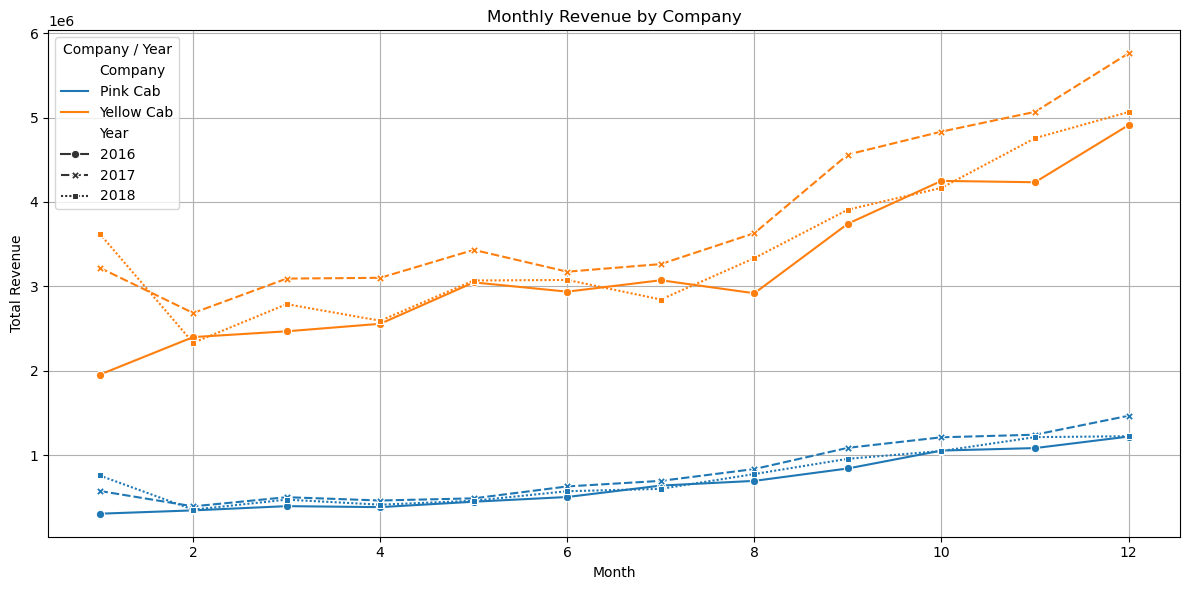

In [27]:
# calculates monthly total revenue by company

# Hypotheses: There is seasonality in cab revenue across months
# Result: Supported - Revenue does increases from July to December for both companies

monthly_revenue = full_data.groupby(["Year", "Month", "Company"])["Price Charged"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x="Month", y="Price Charged", hue="Company", style="Year", markers=True)
plt.title("Monthly Revenue by Company")
plt.ylabel("Total Revenue")
plt.xlabel("Month")
plt.legend(title="Company / Year")
plt.grid()
plt.tight_layout()
plt.show()

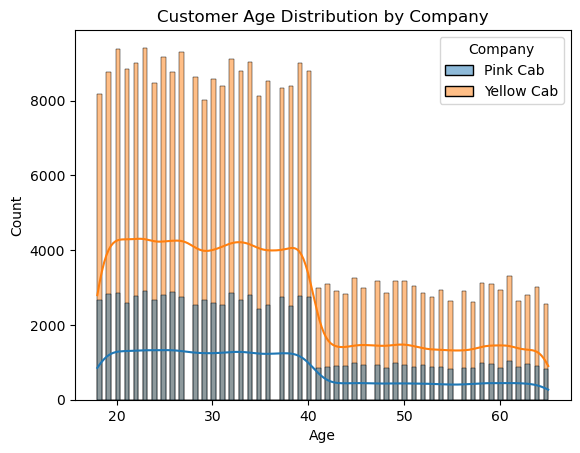

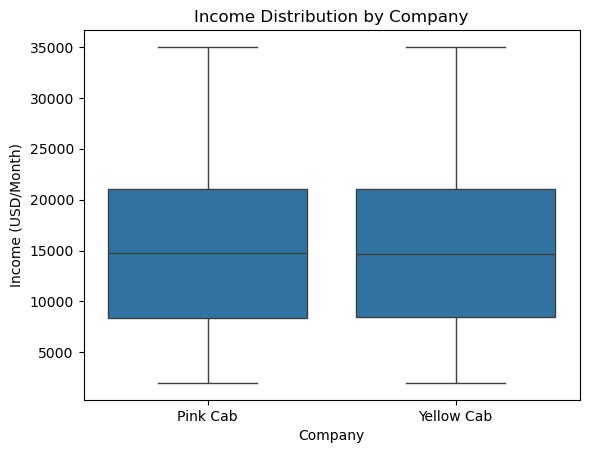

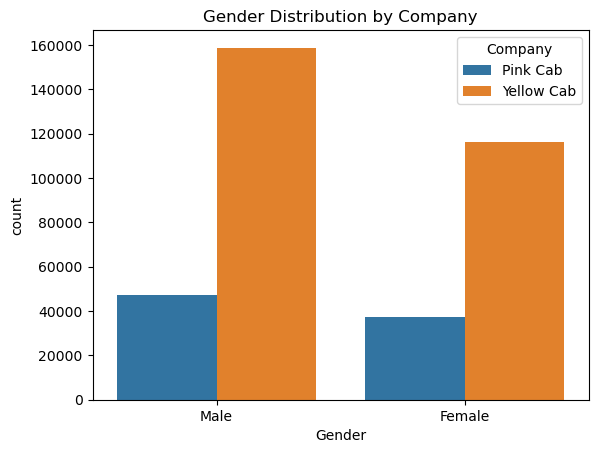

In [28]:
# Hypotheses: Yellow Cab has more users in all age groups 
# Result: Supported - Age distribution shows Yellow Cab dominates 18–60 age range (especially in 18-40)

# age distribution by company
sns.histplot(data=full_data, x="Age", hue="Company", kde=True)
plt.title("Customer Age Distribution by Company")
plt.show()

# Hypotheses: Customers of Yellow Cab have higher income than Pink Cab   
# Result: Not Supported - Income distributions are almost identical for both companies

# income comparison of companies
sns.boxplot(data=full_data, x="Company", y="Income (USD/Month)")
plt.title("Income Distribution by Company")
plt.show()

# Hypotheses: Yellow Cab has more male and female users than Pink Cab   
# Result: Supported - Yellow Cab significantly dominates both genders by a large margin 

# gender distribution by companies
sns.countplot(data=full_data, x="Gender", hue="Company")
plt.title("Gender Distribution by Company")
plt.show()

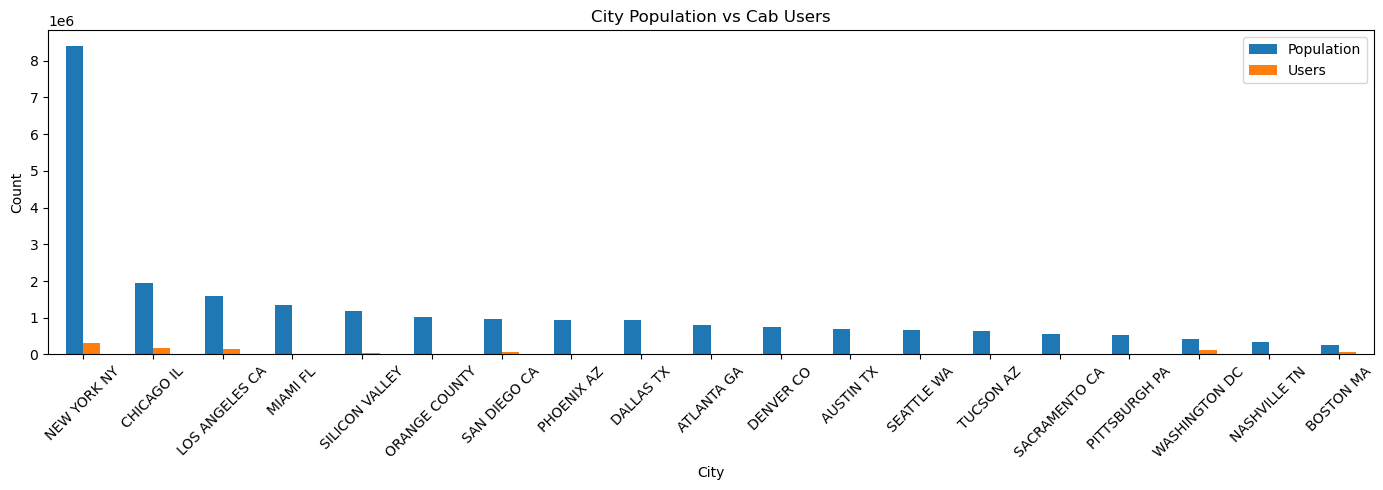

In [29]:
# city populations vs customers

# Hypotheses: Higher population cities have more cab users
# Result: Not Supported - Some high-pop cities like Miami have fewer users than smaller ones

city_summary = full_data.groupby("City")[["Population", "Users"]].mean().sort_values(by="Population", ascending=False)

city_summary.plot(kind="bar", figsize=(14, 5))
plt.title("City Population vs Cab Users")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

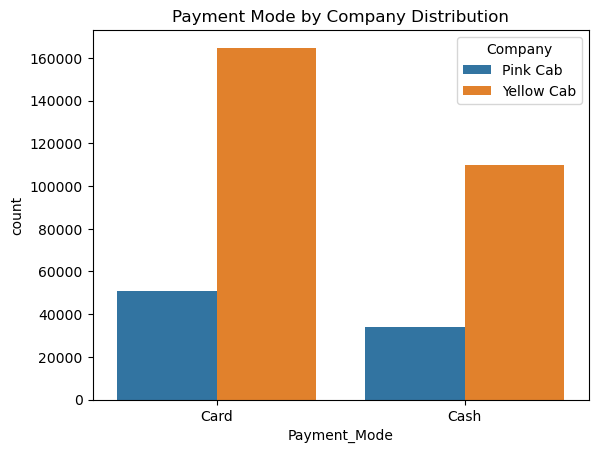

In [30]:
# payment type by company

# Hypotheses: More users pay by card than cash   
# Result: Supported - Card is the most common payment method for both companies 

sns.countplot(data=full_data, x="Payment_Mode", hue="Company")
plt.title("Payment Mode by Company Distribution")
plt.show()

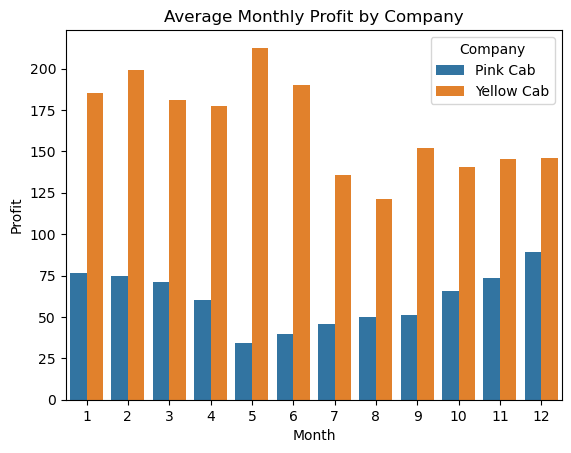

In [31]:
# average monthly profit by company

monthly_profit = full_data.groupby(["Month", "Company"])["Profit"].mean().reset_index()

sns.barplot(data=monthly_profit, x="Month", y="Profit", hue="Company")
plt.title("Average Monthly Profit by Company")
plt.show()

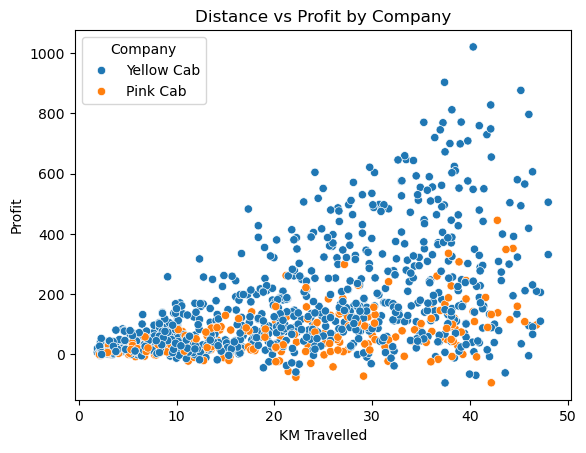

In [32]:
# distance vs profit by company

# Hypotheses: Profit increases with distance travelled   
# Result: Supported - Scatterplot shows clear positive correlation for both companies (larger slope for Yellow Cab)

sns.scatterplot(data=full_data.sample(1000), x="KM Travelled", y="Profit", hue="Company")
plt.title("Distance vs Profit by Company")
plt.show()

In [34]:
# EDA-Based Investment Recommendations

# 1. Invest in Yellow Cab: Higher revenue, stronger profit, and larger user base across genders and age groups
# 2. Target seasonal peaks: Revenue increases in Q3 and Q4, focus marketing and pricing strategies around holiday periods
# 3. Focus on card users: Card is the most common payment method, maybe implement digital loyalty rewards
# 4. Prioritize cities with high cab usage, not just large populations (LA and Chicago show strong usage)
# 5. Monitor Pink Cab: May offer niche potential, but currently underperforms compared to Yellow Cab